In [1]:
'''Model Apporach
1. Load all JSONS
2. Generate optimum topics/clusters from the JSONS by using topic modelling algorithms viz. LDA and LSI
3. Selection of the most suitable model basis optimum coherence and overlapping amongst the topics
3. Classify the questions into topics post which juxtaposing the question onto the relevant documents
'''

'Model Apporach\n1. Load all JSONS\n2. Generate optimum topics/clusters from the JSONS by using topic modelling algorithms viz. LDA and LSI\n3. Selection of the most suitable model basis optimum coherence and overlapping amongst the topics\n3. Classify the questions into topics post which juxtaposing the question onto the relevant documents\n'

In [2]:
import logging
root_abs_path="C:/users/puranik/kaggle covid'19/"
logging.basicConfig(filename=root_abs_path+'logging_lda.log',level=logging.DEBUG)

In [3]:
########Libraries for data structure and data handling
import numpy as np
import pandas as pd
import json as js
from pprint import pprint
########Library for pattern searching on the disk system
import glob as gb
########Library for memory management
import gc
########Libraries to perform NLP analysis for topic modelling
import nltk, spacy, gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore
from gensim.test.utils import common_corpus, common_dictionary
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import gensim
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
#######Library for dumping objects onto the disk system
import pickle
#######Library to aid visual representation of the models
from sklearn.manifold import TSNE
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors


%matplotlib inline

In [4]:
stop_words = stopwords.words('english')
#####Removing additional words as they seem to be more frequent but doesn't seem to add value at broad topic level
stop_words.extend(['from', 'subject', 're', 'edu', 'use','where','what','which','to','there','may','also','would','need','cd'])

In [5]:
######Load JSON files
list_of_files=gb.glob(f"{root_abs_path}/**/*.json",recursive=True)

In [6]:
#######Text cleaner to replace punctuations and carriage returns
def text_cleaner(data):
    data=data.replace("\n"," ").replace(","," ").replace(";"," ").replace(":"," ").replace("\'"," ").replace('\.'," ").replace('?'," ").replace('!'," ")
    return (data)

<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-6-d2e424fed7ed>:3: DeprecationWarning: invalid escape sequence \.
  data=data.replace("\n"," ").replace(","," ").replace(";"," ").replace(":"," ").replace("\'"," ").replace('\.'," ").replace('?'," ").replace('!'," ")


In [7]:
#######JSON reader and consolidater
def file_reader(files):
    df=pd.DataFrame({'paper_id':[None],'title':[None],'abstract':[None],'body':[None],'src_path':[None]})
    for current_file in files:
        with open(current_file) as file:
            row_iter=pd.DataFrame({'paper_id':[None],'title':[None],'abstract':[None],'body':[None],'src_path':[None]})
            json_datafile = js.load(file)
            row_iter['paper_id']=json_datafile['paper_id']
            row_iter['title']=text_cleaner(json_datafile['metadata']['title'])
            abstract_text=[text_cleaner(i['text']) for i in json_datafile['abstract']]
            row_iter['abstract']=" ".join(abstract_text)
            body_text=[text_cleaner(i['text']) for i in json_datafile['body_text']]
            row_iter['body']=" ".join(body_text)
            row_iter['src_path']=current_file
            df=df.append(row_iter,ignore_index=False)
            df=df[df.paper_id==df.paper_id]
            
    return(df)
            

In [8]:
######Tokenize the data into words and removal of punctuations
def words_extract(data):
    for current_data in data:
        yield(gensim.utils.simple_preprocess(str(current_data), deacc=True))

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_trigrams(texts,threshold):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=threshold)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
                                   
    trigram = gensim.models.Phrases(bigram[texts], threshold=threshold)  
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [10]:
######Lemmatize i.e. conversion of words to root words for standardized lookup
def lemmatize(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],max_length=100):
    #"""https://spacy.io/api/annotation"""
    texts_out = []
    nlp.max_length=max_length
    for sent in words:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
#####Approach-1 :LDA 
def compute_coherence_values(dictionary=None, corpus=None, texts=None, limit=None, start=None, step=None,range_start=None,range_limit=None,range_step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    range_limit:Decay Limiter

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        for decay in np.arange(range_start,range_limit,range_step):
            #for alpha in range(1,50,10):
            model=LdaMulticore(corpus=corpus,
                              id2word=id2word,
                              num_topics=num_topics, 
                              random_state=100,
                              chunksize=100,
                              passes=10,
                              #alpha=alpha,
                              per_word_topics=True,
                              decay=decay,
                              workers=11)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
#####Yield a tabular representation containing peculiar information wrt dominant topic,keywords and contribution
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [13]:
%%time
#####Read all the JSON data files
data_file=file_reader(list_of_files)
data_file.head()

Wall time: 3min 37s


,paper_id,title,abstract,body,src_path
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count 194 22 Text word count 5168 23 24...,VP3 and VP0 (which is further processed to VP...,C:/users/puranik/kaggle covid'19\biorxiv_medrx...
0,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...,C:/users/puranik/kaggle covid'19\biorxiv_medrx...
0,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Real-time MinION-based amplicon sequencing f...,Infectious bronchitis (IB) causes significant ...,Infectious bronchitis (IB) which is caused by...,C:/users/puranik/kaggle covid'19\biorxiv_medrx...
0,0139ea4ca580af99b602c6435368e7fdbefacb03,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,C:/users/puranik/kaggle covid'19\biorxiv_medrx...
0,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavir...,Background A novel coronavirus (2019-nCoV) em...,In December 2019 a cluster of patients with p...,C:/users/puranik/kaggle covid'19\biorxiv_medrx...


In [14]:
%%time
####Tokenize the words to enable topic modelling
words=list(words_extract(data_file.body))
gc.collect()

Wall time: 5min 16s


0

In [15]:
%%time
#####Forming trigrams with a relatively high level of stringency to lower the topics universe whilst yet ensuring lower overlapping between topics.
data_words_nostops = remove_stopwords(words)

# Form Trigrams
data_words = make_trigrams(data_words_nostops,threshold=int(0.01*len(list_of_files)))
nlp = spacy.load('en',disable=['parser','ner'])
data_lemmatized = lemmatize(data_words,max_length=max(data_file.body.str.len()))

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 3), (23, 6), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 3), (32, 1), (33, 1), (34, 4), (35, 3), (36, 1), (37, 3), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 9), (47, 1), (48, 2), (49, 1), (50, 3), (51, 3), (52, 2), (53, 3), (54, 1), (55, 2), (56, 1), (57, 2), (58, 1), (59, 2), (60, 1), (61, 3), (62, 2), (63, 1), (64, 6), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 2), (73, 4), (74, 4), (75, 1), (76, 1), (77, 4), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 5), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 5), (101, 2), (102, 1), (103, 1), (104, 1), (105, 2), (106, 2), (107, 1), (108, 1), (109, 1), (110, 1)

[[('able', 1),
  ('absence', 1),
  ('achieve', 1),
  ('addition', 2),
  ('advantage', 3),
  ('adverse', 1),
  ('aflii', 1),
  ('agree', 2),
  ('aii', 1),
  ('alighnment', 1),
  ('allow', 1),
  ('already', 1),
  ('amount', 1),
  ('amplification', 1),
  ('analysis', 1),
  ('appear', 1),
  ('approximately', 1),
  ('aspect', 1),
  ('assay', 1),
  ('assemble', 2),
  ('assembly', 2),
  ('assess', 1),
  ('author_funder_rights_reserve', 3),
  ('author_funder_rights_reserved', 6),
  ('basic', 1),
  ('blast', 1),
  ('calculated', 1),
  ('can', 1),
  ('cell', 3),
  ('change', 1),
  ('check', 1),
  ('clone', 3),
  ('co', 1),
  ('code', 1),
  ('compare', 4),
  ('competent', 3),
  ('competition', 1),
  ('competitive', 3),
  ('complete', 1),
  ('comprise', 1),
  ('confer', 2),
  ('confirm', 1),
  ('conga', 1),
  ('consistent', 3),
  ('construct', 1),
  ('construction', 1),
  ('contain', 9),
  ('containment', 1),
  ('contig', 2),
  ('control', 1),
  ('copy', 3),
  ('copyright_holder_preprint_peer', 3)

In [16]:
%%time
#########LDA model execution:Tuning for number of topics and the decay factors.Alpha and beta are kept at auto
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                       texts=data_lemmatized, 
                                                       start=5, 
                                                       limit=40, 
                                                       step=5,
                                                       corpus=corpus,
                                                       range_start=0.1,
                                                       range_limit=0.9,
                                                       range_step=0.3)

Wall time: 9h 52min 53s


In [17]:
#######Dumping the model objects
file_lda_model = open(root_abs_path+"lda_models_obj", 'wb') 
pickle.dump(model_list, file_lda_model)
coherence_lda_model = open(root_abs_path+"coherence_lda_models_obj", 'wb') 
pickle.dump(coherence_values, coherence_lda_model)
corpus_lda_model=open(root_abs_path+"corpus_lda_models_obj", 'wb') 
pickle.dump(corpus, corpus_lda_model)
dictionary_lda_model=open(root_abs_path+"dictionary_lda_models_obj", 'wb') 
pickle.dump(id2word, dictionary_lda_model)

In [18]:
#######Identification of the coherence scores at iteration level with 2 hyper-parameter viz # of topics and decay
x = range(5, 40, 5)
y=np.arange(0.1,0.9,0.3)
k=0
for topics in x:
    for decay in y:
        print("Iteration:"+str(k)+" Num topics:"+str(topics)+" decay:"+str(decay)+" coherence:"+str(coherence_values[k]))
        k=k+1

Iteration:0 Num topics:5 decay:0.1 coherence:0.45916578801798896
Iteration:1 Num topics:5 decay:0.4 coherence:0.4422800747414777
Iteration:2 Num topics:5 decay:0.7000000000000001 coherence:0.4150360258867666
Iteration:3 Num topics:10 decay:0.1 coherence:0.485303900255873
Iteration:4 Num topics:10 decay:0.4 coherence:0.45804277477346994
Iteration:5 Num topics:10 decay:0.7000000000000001 coherence:0.4289439455047674
Iteration:6 Num topics:15 decay:0.1 coherence:0.5161001750911318
Iteration:7 Num topics:15 decay:0.4 coherence:0.4904257660034682
Iteration:8 Num topics:15 decay:0.7000000000000001 coherence:0.4246720931568814
Iteration:9 Num topics:20 decay:0.1 coherence:0.513243529767944
Iteration:10 Num topics:20 decay:0.4 coherence:0.49018615227674145
Iteration:11 Num topics:20 decay:0.7000000000000001 coherence:0.4191058803685285
Iteration:12 Num topics:25 decay:0.1 coherence:0.53092083630368
Iteration:13 Num topics:25 decay:0.4 coherence:0.4951482534278634
Iteration:14 Num topics:25 dec

In [19]:
########Overlap view across topic clusters(for the voted model i.e. highest coherence)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[12], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.013497  0.085935       1        1  7.379621
21     0.080814 -0.051914       2        1  7.107553
20     0.055419 -0.130825       3        1  6.552782
7      0.041981  0.025391       4        1  5.637927
12     0.054391  0.169271       5        1  5.552279
1      0.028313  0.021546       6        1  5.357094
13    -0.095566  0.166411       7        1  5.126051
9      0.147747 -0.143899       8        1  5.071549
22     0.124170  0.060353       9        1  4.928236
5      0.168756 -0.129938      10        1  4.895564
24    -0.062968  0.183172      11        1  4.496607
19     0.034471 -0.046326      12        1  3.903653
2      0.090353 -0.114146      13        1  3.845850
16     0.115266 -0.002248      14        1  3.669512
10     0.002326  0.192061      15        1  3.570745
4      0.022261  0.099607      16        1  3.433978
17     0.080241  0.008840      17        1  3.319200
6      0.034956 -0.064099      18        1  3.316410
0      0.159818 -0.145527      19        1  3.200529
23    -0.064809  0.101821      20        1  3.175622
18     0.084785 -0.059112      21        1  2.809452
14    -0.134609  0.102785      22        1  2.566068
15    -0.244226  0.064119      23        1  0.689996
3     -0.340532 -0.177433      24        1  0.261524
11    -0.369863 -0.215844      25        1  0.132205, topic_info=           Term           Freq          Total Category  logprob  loglift
317       virus  592267.000000  592267.000000  Default  30.0000  30.0000
28         cell  751653.000000  751653.000000  Default  29.0000  29.0000
994     patient  302438.000000  302438.000000  Default  28.0000  28.0000
372       human  194919.000000  194919.000000  Default  27.0000  27.0000
383   infection  402698.000000  402698.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
1063     source     280.006561   32678.906250  Topic25  -5.6334   1.8689
2650      serum     285.144745   54724.730469  Topic25  -5.6152   1.3715
339        case     339.317932  235273.437500  Topic25  -5.4413   0.0870
238      report     325.984436  185541.125000  Topic25  -5.4814   0.2844
383   infection     335.475677  402698.687500  Topic25  -5.4527  -0.4618

[2048 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9842      1  0.991448  abdominal
9842      3  0.008264  abdominal
4883      1  0.754637   abnormal
4883      2  0.020412   abnormal
4883      4  0.082062   abnormal
...     ...       ...        ...
8192     20  0.992296   zoonosis
2440      6  0.005183   zoonotic
2440     11  0.035626   zoonotic
2440     20  0.900489   zoonotic
2440     25  0.058655   zoonotic

[8594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 22, 21, 8, 13, 2, 14, 10, 23, 6, 25, 20, 3, 17, 11, 5, 18, 7, 1, 24, 19, 15, 16, 4, 12])

In [20]:
######Since overlapping at 25 topics is relatively high,visualizing the overlap with lower number of topics than 25 and the highest coherence amongst them i.e. 20-topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[9], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.011797 -0.096551       1        1  9.284754
9     -0.064873  0.044885       2        1  8.954411
8      0.058586 -0.076054       3        1  8.279463
6     -0.143270  0.083194       4        1  6.978408
7     -0.056351 -0.032317       5        1  6.121921
5     -0.167174  0.074195       6        1  5.748686
1      0.055101  0.007187       7        1  5.744467
16    -0.104460 -0.013958       8        1  5.292420
0     -0.165804  0.095754       9        1  5.094630
10     0.097497 -0.139992      10        1  5.036945
2     -0.123716  0.009145      11        1  4.986578
13     0.169407 -0.100772      12        1  4.433825
17    -0.077356 -0.031654      13        1  4.077594
19    -0.149153  0.037268      14        1  3.969097
4     -0.073282 -0.029546      15        1  3.895069
3      0.001492 -0.052926      16        1  3.379083
14     0.124426 -0.086142      17        1  3.064712
15     0.158446 -0.094412      18        1  2.940289
11     0.195970 -0.031989      19        1  2.578153
18     0.252716  0.434686      20        1  0.139501, topic_info=           Term           Freq          Total Category  logprob  loglift
317       virus  592194.000000  592194.000000  Default  30.0000  30.0000
28         cell  740272.000000  740272.000000  Default  29.0000  29.0000
994     patient  291370.000000  291370.000000  Default  28.0000  28.0000
383   infection  392620.000000  392620.000000  Default  27.0000  27.0000
210     protein  357935.000000  357935.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
483         age     613.597900   88372.960938  Topic20  -4.9026   1.6049
1570      phase     420.163330   34386.984375  Topic20  -5.2813   2.1701
174     observe     498.759674  106208.179688  Topic20  -5.1098   1.2138
905    evidence     400.434631   53692.585938  Topic20  -5.3294   1.6764
2346  technique     366.006653   33889.464844  Topic20  -5.4193   2.0466

[1670 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
9842       3  0.994370    abdominal
9842       4  0.003937    abdominal
9842      17  0.001312    abdominal
5702       3  0.889429  abnormality
5702      10  0.088137  abnormality
...      ...       ...          ...
8192      18  0.999510     zoonosis
2440       7  0.037011     zoonotic
2440      18  0.752114     zoonotic
2440      19  0.210763     zoonotic
17465     14  0.995124         δδct

[6396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 9, 7, 8, 6, 2, 17, 1, 11, 3, 14, 18, 20, 5, 4, 15, 16, 12, 19])

In [21]:
######Since overlapping at 20 topics is relatively high,visualizing the overlap with lower number of topics than 20 and the highest coherence amongst them i.e. 15-topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[6], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.091324 -0.171155       1        1  10.043806
12    -0.093451  0.101691       2        1   9.168773
8     -0.101824 -0.148525       3        1   9.002207
6      0.107350 -0.024378       4        1   8.133546
13    -0.180243 -0.026812       5        1   7.720433
1     -0.041118 -0.083330       6        1   7.599581
0      0.191463 -0.026922       7        1   7.436662
7     -0.011158  0.177952       8        1   7.147423
5      0.052065  0.016458       9        1   6.588323
2      0.087521  0.143770      10        1   6.530338
10    -0.198196  0.078151      11        1   5.666410
14    -0.181133 -0.074149      12        1   4.545004
4     -0.007471 -0.108502      13        1   4.500468
11     0.027961  0.166538      14        1   4.072522
3      0.256910 -0.020787      15        1   1.844507, topic_info=            Term           Freq          Total Category  logprob  loglift
28          cell  741269.000000  741269.000000  Default  30.0000  30.0000
317        virus  553871.000000  553871.000000  Default  29.0000  29.0000
994      patient  301944.000000  301944.000000  Default  28.0000  28.0000
210      protein  359944.000000  359944.000000  Default  27.0000  27.0000
254     sequence  154994.000000  154994.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
1579    position    7522.207031   27170.179688  Topic15  -4.9783   2.7087
46       contain    9073.485352  115572.203125  Topic15  -4.7908   1.4484
1470  expression    8912.841797  123505.156250  Topic15  -4.8086   1.3642
316        viral    9358.713867  230658.843750  Topic15  -4.7598   0.7883
315       vector    7059.381836   45889.500000  Topic15  -5.0418   2.1211

[1345 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
29310     12  0.997559     abattoir
9842       3  0.984396    abdominal
9842       4  0.005969    abdominal
9842      12  0.009550    abdominal
5702       1  0.005119  abnormality
...      ...       ...          ...
1103      14  0.000479         year
2440       2  0.058549     zoonotic
2440       6  0.790649     zoonotic
2440      11  0.052634     zoonotic
2440      12  0.098075     zoonotic

[4778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 9, 7, 14, 2, 1, 8, 6, 3, 11, 15, 5, 12, 4])

In [23]:
######Selection of optimal model of approach-1 with relatively high coherence and low overlapping across topic clusters using the aformentioned 3 -visualization iterations
optimal_model_approach_1 = model_list[6]
model_topics_apporach_1 = optimal_model_approach_1.show_topics(formatted=True)
pprint(optimal_model_approach_1.print_topics(num_words=100))

[(0,
  '0.054*"protein" + 0.017*"bind" + 0.014*"domain" + 0.012*"structure" + '
  '0.011*"membrane" + 0.008*"residue" + 0.008*"fusion" + 0.008*"form" + '
  '0.008*"site" + 0.008*"figure" + 0.007*"peptide" + 0.007*"interaction" + '
  '0.007*"contain" + 0.007*"show" + 0.007*"acid" + 0.006*"fig" + '
  '0.006*"complex" + 0.005*"amino" + 0.005*"region" + 0.005*"sequence" + '
  '0.005*"activity" + 0.005*"terminal" + 0.004*"use" + 0.004*"receptor" + '
  '0.004*"surface" + 0.004*"structural" + 0.004*"suggest" + 0.004*"find" + '
  '0.004*"chain" + 0.004*"cleavage" + 0.003*"enzyme" + 0.003*"viral" + '
  '0.003*"target" + 0.003*"mutant" + 0.003*"see" + 0.003*"function" + '
  '0.003*"golgi" + 0.003*"indicate" + 0.003*"molecule" + 0.003*"result" + '
  '0.003*"different" + 0.003*"similar" + 0.003*"formation" + 0.003*"protease" '
  '+ 0.003*"cell" + 0.003*"vesicle" + 0.003*"transport" + 0.003*"type" + '
  '0.003*"core" + 0.003*"however" + 0.003*"study" + 0.003*"identify" + '
  '0.003*"process" + 0.00

In [24]:
########Approach-2:LSI(i.e. Challenger model)
def preprocess_data(doc_set,stop_words):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in stop_words]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [25]:
######
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [26]:
def compute_coherence_values_1(dictionary, doc_term_matrix, doc_clean, stop, start, step,range_start,range_stop,range_step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        for decay in np.arange(range_start,range_stop,range_step):
        # generate LSA model
            model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
%%time
#######Pre-porcess the data i.e. tokenize the body
pre_processed_data=preprocess_data(data_file.body,stop_words)

In [ ]:
%%time
#######Preparation of corpus of words
dic,doc=prepare_corpus(pre_processed_data)

In [ ]:
%%time
#######Generation of coherence values to statistically determine the optimum
model_list_1,coherence_values_1=compute_coherence_values_1(dictionary=dic,
                                                    doc_term_matrix=doc,
                                                    doc_clean=pre_processed_data,
                                                    start=5, 
                                                    stop=40, 
                                                    step=5,
                                                    range_start=0.1,
                                                    range_stop=0.9,
                                                    range_step=0.3)

In [ ]:
x = range(5, 40, 5)
y=np.arange(0.1,0.9,0.3)
k=0
for topics in x:
    for decay in y:
        print("Iteration:"+str(k)+" Num topics:"+str(topics)+" decay:"+str(decay)+" coherence:"+str(coherence_values_1[k]))
        k=k+1

In [ ]:
######Final Model Selection:As coherence score from approach 1 i.e. LDA(0.5078241103238144)>approach 2 i.e LSA (0.42155339688251947),we will select approach-1


In [ ]:
%%time
#########Identifying the dominant topic per document,i.e. classify documents into clusters basis topics
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model_approach_1, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

In [ ]:
######Generate the topic wise word master to enable easy seraching for keywords
# Topic-Keyword Matrix
topic_words = pd.DataFrame()
grpd_dominant_topic= df_dominant_topic.groupby('Dominant_Topic')

for i, grp in grpd_dominant_topic:
    topic_words = pd.concat([topic_words, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topic_words.reset_index(drop=True, inplace=True)

# Format
#topic_words.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]

# Show
topic_words.head(10)

In [ ]:
#######Prediction helper to probabilistically tag the text to topic
def predict_topic(text, nlp=nlp,lda_model=None,id2word=None):
    '''Inputs
    text:new text to predict
    lda_model:model object
    id2word: pre-created dictionary
    
    '''
    global words_extract
    global lemmatize
    global prepare_corpus

    # Step 1: Extract words from the string
    text1 = list(words_extract(text))
    # Step 2:Remove stop words
    text2 = remove_stopwords(text1)
    # Step 3: Lemmatize
    text2 = lemmatize(text2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    #Step 4 Corpus
    text3=[id2word.doc2bow(text) for text in text2]
    # Step 4: Running the LDA Clustering to 
    topic_probability_scores = optimal_model_approach_1.get_document_topics(text3)
    print([i for i in optimal_model_approach_1.get_document_topics(text3)])
    

In [790]:
######Merging of the document-wise topic with the base-file for indexing
df_dominant_topic=df_dominant_topic.sort_values(by='Document_No',ascending=True)
data_file1 = pd.concat([data_file.reset_index(drop=True), df_dominant_topic], axis=1)

In [755]:
import  re
######Function to detect numeric and alphabetical days for matching incubation  
def pattern_find(text):
    final_text=""
    a1=""
    b=""
    t=re.findall(r"([^.]*?incubation[^.]*\.)",text) 
    if(len(t)>0):
        temp=t
    else:
        temp=text
    #print(temp)
    if(type(temp)==list):
        for i in temp:
            if(len(re.findall("human|sapein|person|homo",i))>0):
                final_text=i
                break
            elif(i==temp[len(temp)-1]):
                final_text=i
    else:
        final_text=temp
        #final_text=final_text[final_text!='']      
    
    if(type(final_text)==str):
        #print(final_text)
        if(len(re.findall("from[\\s]+",final_text))>0):
            a1=re.findall("from[\\s]+[0-9]{1,}",final_text)
            b=re.findall("from[\\s]+one{1,}|from[\\s]+two{1,}|from[\\s]+twen{1,}|from[\\s]+three{1,}|from[\\s]+thirt{1,}|from[\\s]+four{1,}|from[\\s]+forty{1,}|from[\\s]+five{1,}|from[\\s]+fift{1,}|from[\\s]+six{1,}|from[\\s]+sixty{1,}|from[\\s]+seven{1,}|from[\\s]+eight{1,}|from[\\s]+nine{1,}|from[\\s]+nint{1,}",final_text)
        elif(len(re.findall("for[\\s]+",final_text))>0):
            a1=re.findall("for[\\s]+[0-9]{1,}",final_text)
            b=re.findall("for[\\s]+one{1,}[\\s]+|for[\\s]+two{1,}|for[\\s]+twen{1,}|for[\\s]+three{1,}|for[\\s]+thirt{1,}|for[\\s]+four{1,}|for[\\s]+forty{1,}|for[\\s]+five{1,}|for[\\s]+fift{1,}|for[\\s]+six{1,}|for[\\s]+sixty{1,}|for[\\s]+seven{1,}|for[\\s]+eight{1,}|for[\\s]+nine{1,}|for[\\s]+nint{1,}",final_text)
        elif(len(re.findall("of[\\s]+",final_text))>0):
            a1=re.findall("of[\\s]+[0-9]{1,}",final_text)
            b=re.findall("of[\\s]+one{1,}[\\s]+|of[\\s]+two{1,}|of[\\s]+twen{1,}|of[\\s]+three{1,}|of[\\s]+thirt{1,}|of[\\s]+four{1,}|of[\\s]+forty{1,}|of[\\s]+five{1,}|of[\\s]+fift{1,}|of[\\s]+six{1,}|of[\\s]+sixty{1,}|of[\\s]+seven{1,}|of[\\s]+eight{1,}|of[\\s]+nine{1,}|of[\\s]+nint{1,}",final_text)
        elif(len(re.findall("after[\\s]+",final_text))>0):
            a1=re.findall("after[\\s]+[0-9]{1,}",final_text)
            b=re.findall("after[\\s]+one{1,}[\\s]+|after[\\s]+two{1,}|after[\\s]+twen{1,}|after[\\s]+three{1,}|after[\\s]+thirt{1,}|after[\\s]+four{1,}|after[\\s]+forty{1,}|after[\\s]+five{1,}|after[\\s]+fift{1,}|after[\\s]+six{1,}|after[\\s]+sixty{1,}|after[\\s]+seven{1,}|after[\\s]+eight{1,}|after[\\s]+nine{1,}|after[\\s]+nint{1,}",final_text)
            
        if(len(a1)>0):
            v=re.findall("[\\s]+to[\\s]+one{1,}|[\\s]+to[\\s]+two{1,}|[\\s]+to[\\s]+twen{1,}|[\\s]+to[\\s]+three{1,}|[\\s]+to[\\s]+thirt{1,}|[\\s]+to[\\s]+four{1,}|[\\s]+to[\\s]+forty{1,}|[\\s]+to[\\s]+five{1,}|[\\s]+to[\\s]+fift{1,}|[\\s]+to[\\s]+six{1,}|[\\s]+to[\\s]+sixty{1,}|[\\s]+to[\\s]+seven{1,}|[\\s]+to[\\s]+eight{1,}|[\\s]+to[\\s]+nine{1,}|[\\s]+to[\\s]+nint{1,}|[\\s]+to[\\s]+\\d{1,}",final_text)
            x=re.findall("[\\s]{1,}-[\\s]{1,}one{1,}|[\\s]{1,}-[\\s]{1,}two{1,}|[\\s]{1,}-[\\s]{1,}twen{1,}|[\\s]{1,}-[\\s]{1,}three{1,}|[\\s]{1,}-[\\s]{1,}thirt{1,}|[\\s]{1,}-[\\s]{1,}four{1,}|[\\s]{1,}-[\\s]{1,}forty{1,}|[\\s]{1,}-[\\s]{1,}five{1,}|[\\s]{1,}-[\\s]{1,}fift{1,}|[\\s]{1,}-[\\s]{1,}six{1,}|[\\s]{1,}-[\\s]{1,}sixty{1,}|[\\s]{1,}-[\\s]{1,}seven{1,}|[\\s]{1,}-[\\s]{1,}eight{1,}|[\\s]{1,}-[\\s]{1,}nine{1,}|[\\s]{1,}-[\\s]{1,}nint{1,}|[\\s]{1,}[\\s]{1,}-[\\s]{1,}\\d{1,}",final_text)
            a1=re.sub("from","","".join(a1))
            a1=re.sub("for","","".join(a1))
            a1=re.sub("of","","".join(a1))
            a1=re.sub("after","","".join(a1))
            a1=re.sub("to","","".join(a1))
            if(len(v)>0):
                v=re.sub("to","","".join(v))
                
                return(a1+" to "+v[0])
            elif(len(x)>0):
                x=re.sub("-","","".join(x))
                return(a1+" to "+x[0])
            else:
                return(a1)
        if(len(b)>0):
            v=re.findall("[\\s]+to[\\s]+one{1,}|[\\s]+to[\\s]+two{1,}|[\\s]+to[\\s]+twen{1,}|[\\s]+to[\\s]+three{1,}|[\\s]+to[\\s]+thirt{1,}|[\\s]+to[\\s]+four{1,}|[\\s]+to[\\s]+forty{1,}|[\\s]+to[\\s]+five{1,}|[\\s]+to[\\s]+fift{1,}|[\\s]+to[\\s]+six{1,}|[\\s]+to[\\s]+sixty{1,}|[\\s]+to[\\s]+seven{1,}|[\\s]+to[\\s]+eight{1,}|[\\s]+to[\\s]+nine{1,}|[\\s]+to[\\s]+nint{1,}|[\\s]+to[\\s]+\\d{1,}",final_text)
            x=re.findall("[\\s]{1,}-[\\s]{1,}one{1,}|[\\s]{1,}-[\\s]{1,}two{1,}|[\\s]{1,}-[\\s]{1,}twen{1,}|[\\s]{1,}-[\\s]{1,}three{1,}|[\\s]{1,}-[\\s]{1,}thirt{1,}|[\\s]{1,}-[\\s]{1,}four{1,}|[\\s]{1,}-[\\s]{1,}forty{1,}|[\\s]{1,}-[\\s]{1,}five{1,}|[\\s]{1,}-[\\s]{1,}fift{1,}|[\\s]{1,}-[\\s]{1,}six{1,}|[\\s]{1,}-[\\s]{1,}sixty{1,}|[\\s]{1,}-[\\s]{1,}seven{1,}|[\\s]{1,}-[\\s]{1,}eight{1,}|[\\s]{1,}-[\\s]{1,}nine{1,}|[\\s]{1,}-[\\s]{1,}nint{1,}|[\\s]{1,}[\\s]{1,}-[\\s]{1,}\\d{1,}",final_text)
            b=re.sub("from","","".join(b))
            b=re.sub("for","","".join(b))
            b=re.sub("of","","".join(b))
            b=re.sub("to","","".join(b))
            if(len(v)>0):
                v=re.sub("to","","".join(v))
                return(b+" to "+v[0])
            elif(len(x)>0):
                x=re.sub("-","","".join(x))
                return(b+" to "+x[0])
            else:
                return(b)
        
        
    return(None)


In [505]:
######Task 1.1 Incubation
text= ["incubation periods for the disease in humans"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.0133348), (1, 0.5460623), (2, 0.0133348), (3, 0.013334798), (4, 0.013334813), (5, 0.013334805), (6, 0.28058484), (7, 0.013334887), (8, 0.013334823), (9, 0.013334803), (10, 0.0133349), (11, 0.013334857), (12, 0.013334817), (13, 0.01333485), (14, 0.013334889)]]


D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


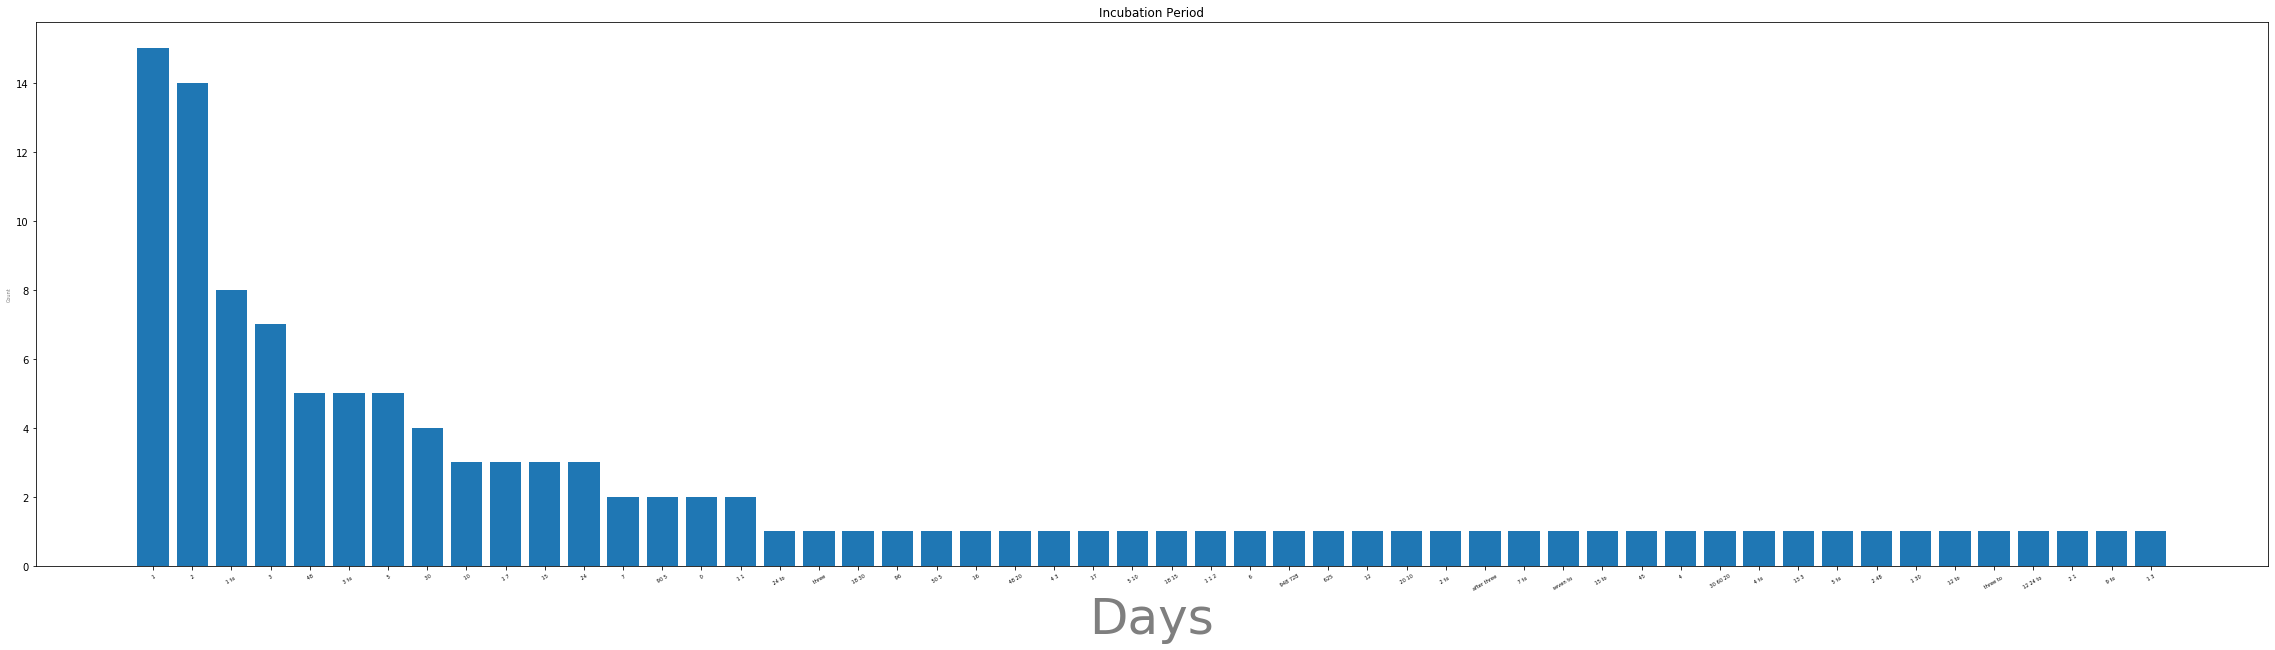

In [770]:
######Task 1.1 Incubation Charting
df_apt_filter=data_file1[data_file1.Dominant_Topic==1]
df_apt_filter['body']=df_apt_filter.body.str.lower()
df_apt_filter=df_apt_filter[df_apt_filter.body.str.contains('incubation')]
df_apt_filter['extract_hit']=df_apt_filter.body.apply(pattern_find)
incubation=df_apt_filter[df_apt_filter['extract_hit']==df_apt_filter['extract_hit']]
table=incubation.extract_hit.value_counts()
plt.figure(figsize=(40,10))
plt.bar(np.arange(len(table)), table.values)
plt.xlabel('Days', fontsize=100,alpha=0.2)
plt.ylabel('Count', fontsize=5,alpha=0.5)
plt.xticks(np.arange(len(table)),table.index, fontsize=5, rotation=30)
plt.title('Incubation Period')
plt.show()

In [771]:
######Task 1.2 Prevalence of asymptomatic shedding and transmission (e.g., particularly children).
text= ["prevalence of asymptomatic shedding and transmission"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.022224005), (1, 0.022224052), (2, 0.022224005), (3, 0.022224005), (4, 0.022224005), (5, 0.022224005), (6, 0.022224005), (7, 0.022224005), (8, 0.02222401), (9, 0.022224005), (10, 0.68886375), (11, 0.02222402), (12, 0.022224005), (13, 0.022224052), (14, 0.022224028)]]


In [775]:
######Task 1.2 Prevalence of asymptomatic shedding and transmission Subset
data_file1[data_file1.Dominant_Topic==10]
df_apt_filter['body']=df_apt_filter.body.str.lower()
asymptotic_transmission=df_apt_filter[df_apt_filter.body.str.contains('asymptotic|shedding|transmission',regex=True)]
asymptotic_transmission.head()

In [776]:
######Task 1.3 seasonality transmission
text= ["seasonality transmission"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.02226504), (1, 0.02226506), (2, 0.02226504), (3, 0.02226504), (4, 0.02226504), (5, 0.02226504), (6, 0.02226504), (7, 0.022265168), (8, 0.02226504), (9, 0.02226504), (10, 0.688289), (11, 0.022265173), (12, 0.02226504), (13, 0.022265213), (14, 0.022265041)]]


In [780]:
######Task 1.3 seasonality transmission Subset
data_file1[data_file1.Dominant_Topic==10]
df_apt_filter['body']=df_apt_filter.body.str.lower()
seasonality_transmission=df_apt_filter[df_apt_filter.body.str.contains('seasonality|transmission',regex=True)]
seasonality_transmission.head()

,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
459,87bfa13221ccf5a02d4a888ef1320b57f2c2d5e2,REPROGRAMMED PTEROPUS BAT STEM CELLS PRESENT DISTINCT IMMUNE SIGNATURE AND ARE HIGHLY PERMISSIVE FOR 2 HENIPAVIRUSES 3 4 5 Summary sentence Somatic reprogramming provides new bat stem cells with unique immune,Bats are unique among mammals due to the ability of powered flight and exceptional longevity. They 2 are also asymptomatic hosts for numerous viruses including recently emerged zoonotic 3 Henipaviruses Nipah and Hendra which are highly pathogenic for humans and other mammals. 4 Better understanding of how bats control viral infection requires development of relevant permissive 5 cellular experimental models. By applying a somatic reprogramming protocol to Pteropus bat primary 6 cells using a novel combination of ESRRB CDX2 and c-MYC transcription factors we generated 7 bat reprogrammed cells exhibiting stem cell-like characteristics and a neural stem cell-like molecular 8 signature. These cells present a unique interferon-stimulated transcriptomic signature and both 9 produce and respond to interferon type-I highlighting differences between stem cells from bats and 10 other mammals. In contrast to primary bat cells these reprogrammed cells are highly susceptible to 11 infec...,emergence of zoonotic diseases is increasing globally thus the ability to predict and prevent viral 3 epidemics is a major objective for public health organizations. among all emerging infectious 4 diseases approximately 60% are of zoonotic origin 1 . bats host a large number of human and animal 5 zoonotic viruses including henipaviruses 2 (nipah (niv) and hendra (hev)) coronaviruses (severe 6 acute respiratory syndrome (sars-cov) 3 and middle east respiratory (mers-cov)) 4 and 7 filoviruses (marburg 5 and ebola viruses 6 ). these agents are among the most virulent pathogens 8 emerging from animal reservoirs and are capable of infecting a broad range of species including 9 humans while remaining asymptomatic in bats. transmission of niv from bats to humans occurs 10 either through intermediate host contamination 7 8 or directly 9 via consumption of fruits or raw date 11 palm juice contaminated with bat saliva or urine. in the case of niv-bangladesh isolates this may be 12...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\87bfa13221ccf5a02d4a888ef1320b57f2c2d5e2.json,"<re.Match object; span=(6458, 6464), match='30 day'>",0,459,1.0,0.3231,"virus, infection, viral, human, host, infect, specie, disease, animal, strain","[emergence, zoonotic, disease, increase, globally, thus, ability, predict, prevent, viral, epidemic, major, objective, public, health, organization, emerge, infectious, disease, approximately, zoonotic, origin, bat, host, large, number, human, animal, zoonotic, virus, include, hev, coronaviruse, severe, acute, filoviruse, viruse, agent, virulent, pathogen, emerge, animal, reservoir, capable, infect, broad, range, specie, include, human, remain, asymptomatic, bat, transmission, bat, human, occur, intermediate, host, contamination, directly, consumption, fruit, raw, date, contaminate, bat, case, isolate, follow, inter, human, transmission, henipaviruse, negative, responsible, respiratory, neurological, respectively, fatality, rate, virus, detect, molecularly, serologically, pteropus, bat, different, asian, african, country, worldwide, distribution, bat, specie, pose, threat, future, pandemic, bat, ...]"
1125,060201d43460ac305a26ac4b0acca66cd41c151a,The Search for a Practical Approach to Emerging Diseases The Case of Severe Acute Respiratory Syndrome (SARS),,perhaps the most intimate relationship between the environment and the development of the vertebrate species is the interaction of the immune system with infectious disease agents. this is best exemplified by antigenic variations that occur in infectious disease agents such as viral peptides and the cor

In [781]:
######Task 1.4 physical science
text= ["physical science"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.022226958), (1, 0.022226945), (2, 0.022226956), (3, 0.022226945), (4, 0.022226945), (5, 0.022226997), (6, 0.022226952), (7, 0.02222698), (8, 0.022227084), (9, 0.022226948), (10, 0.022226982), (11, 0.02222696), (12, 0.68882245), (13, 0.022226965), (14, 0.022226956)]]


In [782]:
######Task 1.4 physical science Subset
data_file1[data_file1.Dominant_Topic==10]
df_apt_filter['body']=df_apt_filter.body.str.lower()
physical_science=df_apt_filter[df_apt_filter.body.str.contains('charge distribution|hydrophilic|phobic|environmental survival|decontamination|viral shedding|physical science',regex=True)]
physical_science.head()


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1243,09b0945d4963d363bb670d75070c19a328fbfce6,Tropical Medicine and Infectious Disease Paramyxo-and Coronaviruses in Rwandan Bats,A high diversity of corona-and paramyxoviruses have been detected in different bat species at study sites worldwide including Africa however no biosurveillance studies from Rwanda have been reported. In this study samples from bats collected from caves in Ruhengeri Rwanda were tested for the presence of corona-and paramyxoviral RNA using reverse transcription PCR assays. Positive results were further characterized by DNA sequencing and phylogenetic analysis. In addition to morphological identification of bat species we also did molecular confirmation of species identities contributing to the known genetic database available for African bat species. We detected a novel Betacoronavirus in two Geoffroy s horseshoe bats (Rhinolophus clivosus) bats. We also detected several different paramyxoviral species from various insectivorous bats. One of these viral species was found to be homologous to the genomes of viruses belonging to the Jeilongvirus genus. Additionally a Henipavirus...,bats (order chiroptera) account for 20% of all mammalian species and are distributed worldwide. with the advancement in detection techniques and increased surveillance bats are being increasingly recognized as hosts for many zoonotic viruses [1] including filo- paramyxo- corona-and lyssaviruses [2] [3] [4] [5] . regions in africa are considered a hotspot for emerging infectious diseases with more than 50% of recently emerging diseases originating from wildlife species on this continent [6 7] . although several surveillance studies have been implemented to detect potential zoonotic viruses in bats including from countries in the congo basin and east africa limited information is available for rwanda. importantly in the bordering democratic republic of congo and uganda marburg and ebola disease outbreaks in humans have occurred [8] and corona-and paramyxoviruses have been reported to circulate in bats [3 [9] [10] [11] . coronaviruses are positive-sense rna viruses with t...,C:/users/puranik/kaggle covid'19\comm_use_subset\comm_use_subset\09b0945d4963d363bb670d75070c19a328fbfce6.json,None,20 10,1243,1.0,0.4177,"virus, infection, viral, human, host, infect, specie, disease, animal, strain","[bat, account, mammalian, specie, distribute, worldwide, advancement, detection, technique, increase, surveillance, bat, increasingly, recognize, host, many, zoonotic, virus, include, paramyxo, lyssaviruse, consider, emerge, infectious, disease, recently, emerge, disease, originate, wildlife, specie, continent, several, surveillance, study, implement, detect, potential, zoonotic, virus, bat, include, country, limit, information, available, importantly, border, human, occur, corona, paramyxovirus, report, circulate, bat, coronaviruse, positive, sense, viruse, potential, cause, respiratory, hepatic, neurological, disease, host, divide, namely, bat, host, large, diversity, coronaviruse, expand, research, largely, attribute, emergence, novel, coronaviruse, public, health, veterinary, importance, virus, emerge, last, year, include, severe, acute, syndrome, sad, coronaviruse, show, associate, particular, similar, virus, identify, ...]"
1677,16c14c63746634d9cc1a2d4257b7d7560af187ba,Alphavirus Mutator Variants Present Host-Specific Defects and Attenuation in Mammalian and Insect Models,Arboviruses cycle through both vertebrates and invertebrates which requires them to adapt to disparate hosts while maintaining genetic integrity during genome replication. To study the genetic mechanisms and determinants of these processes we use chikungunya virus (CHIKV) a re-emerging human pathogen transmitted by the Aedes mosquito. We previously isolated a high fidelity (or antimutator) polymerase variant C483Y which had decreased fitness in both

In [786]:
######Task 1.5 persistence and stability
text= ["Persistence and stability on a multitude of substrates and sources"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.013383533), (1, 0.013383525), (2, 0.0133835105), (3, 0.01338354), (4, 0.013383507), (5, 0.8126307), (6, 0.013383503), (7, 0.013383504), (8, 0.013383509), (9, 0.013383521), (10, 0.013383521), (11, 0.013383518), (12, 0.013383543), (13, 0.013383499), (14, 0.013383513)]]


In [792]:
######Task 1.4 persistence and stability subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([5])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
persistence_substrate=df_apt_filter[df_apt_filter.body.str.contains('(persistence*substrate)|(stability*substrate)|sources|nasal disharge|fecal|sputum|blood|urine',regex=True)]
persistence_substrate.head()


D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Software\Anaconda\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
33,0aff00101d5ccc6592987185ab833f95d842f98b,Potentially highly potent drugs for 2019-nCoV,The World Health Organization (WHO) has declared the 2019 novel coronavirus (2019-nCoV) infection outbreak a global health emergency. Currently there is no effective anti-2019-nCoV medication. The sequence identity of the 3CL proteases of 2019-nCoV and SARS is 96% which provides a sound foundation for structural-based drug repositioning (SBDR). Based on a SARS 3CL protease X-ray crystal structure we construct a 3D homology structure of 2019-nCoV 3CL protease. Based on this structure and existing experimental datasets for SARS 3CL protease inhibitors we develop an SBDR model based on machine learning and mathematics to screen 1465 drugs in the DrugBank that have been approved by the U.S. Food and Drug Administration (FDA). We found that many FDA approved drugs are potentially highly potent to 2019-nCoV.,"the 2019 novel coronavirus (2019-ncov) caused the pneumonia outbreak in wuhan china in late december 2019 and has rapidly spread around the world. by feb 5 2020 more than 24000 individuals were infected and more than 490 fatalities had been reported. the world health organization (who) has declared this novel coronavirus outbreak a global health emergency. currently there is no specific antiviral drug for this epidemic. considering the severity of this widespread dissemination and health threats panic patients misled by media flocked to the pharmacies for chinese medicine herbs which were reported to ""inhibit"" the 2019-ncov despite no clinical evidence supporting the claim. many researchers are engaged in developing anti-2019-ncov drug s [1 2] . however new drug discovery and development is a long costly and rigorous scientific process. a more effective approach is to search for anti-2019-ncov therapies from the existing fda-approved drug database. drug repositioning (als...",C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\0aff00101d5ccc6592987185ab833f95d842f98b.json,None,None,33,5.0,0.2820,"use, drug, activity, concentration, compound, effect, show, high, base, system","[cause, late, rapidly, spread, individual, infect, fatality, report, organization, declare, novel, global, health, emergency, currently, specific, antiviral, drug, epidemic, consider, severity, widespread, dissemination, health, threat, panic, patient, mislead, medium, flock, pharmacy, chinese, medicine, herb, report, ncov, clinical, evidence, support, claim, many, researcher, engage, develop, anti, ncov, drug, however, new, drug, discovery, long, costly, rigorous, scientific, process, effective, approach, search, anti, ncov, therapy, exist, drug, database, drug, reposition, know, drug, repurposing, concern, investigation, exist, drug, new, therapeutic, target, indication, emerge, successful, strategy, drug, discovery, due, reduce, cost, expedite, approval, procedure, several, successful, example, unveil, great, value, practice, initially, develop, treat, human, ...]"
64,123db7cdec9fc63aa09782ea9f4267603be8f74d,DNA-scaffolded biomaterials enable modular and tunable control of cell-based cancer immunotherapies,Advanced biomaterials provide versatile ways to spatially and temporally control immune cell activity potentially enhancing their therapeutic potency and safety. Precise cell modulation demands multi-modal display of functional proteins with controlled densities on biomaterials. Here we develop an artificial immune cell engager (AICE) platform -biodegradable particles onto which multiple proteins are densely loaded with ratiometric control via short nucleic acid tethers. We demonstrate the impact of AICE with varying ratios of anti-CD3 and anti-CD28 antibodies on ex vivo expansion of human primary T cells. We also show that AICE can be used to control the activity of engineered T cells in vivo. AICE injected intratumorally can

In [793]:
######Task 1.6 persistence on materials
text= ["persistence on material"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)
#Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).

Topic-Probability pair
[[(0, 0.03333485), (1, 0.033334874), (2, 0.033334937), (3, 0.033334848), (4, 0.033334848), (5, 0.53331184), (6, 0.033334907), (7, 0.03333485), (8, 0.033334877), (9, 0.033334848), (10, 0.033334866), (11, 0.033334848), (12, 0.033334874), (13, 0.033334848), (14, 0.033334866)]]


In [794]:
######Task 1.6 persistence on materials Subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([5])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
persistence_material=df_apt_filter[df_apt_filter.body.str.contains('(copper)|(steel)|iron|metal|alloys|cloth|body|plastic|wood|handle',regex=True)]
persistence_material.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Software\Anaconda\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
8,0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5,Carbon Nanocarriers Deliver siRNA to Intact Plant Cells for Efficient Gene,Post-transcriptional gene silencing (PTGS) is a powerful tool to understand and control plant metabolic pathways which is central to plant biotechnology. PTGS is commonly accomplished through delivery of small interfering RNA (siRNA) into cells. Standard plant siRNA delivery methods (Agrobacterium and viruses) involve coding siRNA into DNA vectors and are only tractable for certain plant species. Herein we develop a nanotube-based platform for direct delivery of siRNA and show high silencing efficiency in intact plant cells. We demonstrate that nanotubes successfully deliver siRNA and silence endogenous genes owing to effective intracellular delivery and nanotubeinduced protection of siRNA from nuclease degradation. This study establishes that nanotubes could enable a myriad of plant biotechnology applications that rely on RNA delivery to intact cells. All rights reserved. No reuse allowed without permission.,sirna without relying on plant transformation however most viruses are limited in their host range (13) often do not result in uniform silencing of the gene and thus levels of silencing can vary between plants and experiments (14) and might inadvertently result in the suppression of non-target genes. agrobacterium-mediated delivery similarly is also limited to use in certain plant species often yields random dna integration that can adversely and unpredictably affect the cell operation (15) results in constitutive expression of sirna thus limiting temporal control over gene silencing and can be difficult to scale or multiplex for high-throughput or multi-gene target applications respectively (16) . while nanomaterial-mediated delivery of rna and therapeutics has been extensively explored in animals (17) (18) (19) its potential for plant systems remains understudied (20) . several prior studies take advantage of nanomaterials to deliver plasmid dna (21) (22) (23) (24...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5.json,"<re.Match object; span=(4783, 4788), match='7 day'>",None,8,5.0,0.4308,"use, drug, activity, concentration, compound, effect, show, high, base, system","[rely, plant, transformation, however, viruse, limited, host, range, often, result, uniform, silence, gene, thus, level, silence, vary, plant, experiment, may, inadvertently, result, suppression, non, target, gene, agrobacterium, mediate, delivery, similarly, limit, certain, plant, specie, often, yield, random, dna, integration, adversely, unpredictably, affect, cell, operation, result, constitutive, expression, thus, limit, temporal, control, gene, silence, difficult, scale, multiplex, high, throughput, multi, gene, target, application, respectively, nanomaterial, mediate, delivery, therapeutic, extensively, explore, animal, potential, plant, system, remain, understudy, several, prior, study, take, advantage, nanomaterial, deliver, plasmid, dna, protein, intact, plant, cell, polymeric, nanoparticle, show, promise, delivery, cell, plant, protoplast, polymeric, nanoparticle, show, traverse, ...]"
33,0aff00101d5ccc6592987185ab833f95d842f98b,Potentially highly potent drugs for 2019-nCoV,The World Health Organization (WHO) has declared the 2019 novel coronavirus (2019-nCoV) infection outbreak a global health emergency. Currently there is no effective anti-2019-nCoV medication. The sequence identity of the 3CL proteases of 2019-nCoV and SARS is 96% which provides a sound foundation for structural-based drug repositioning (SBDR). Based on a SARS 3CL protease X-ray crystal structure we construct a 3D homology structure of 2019-nCoV 3CL protease. Based on this structure and existing experimental datasets for SARS 3CL protease inhibitors we develop an SBDR model based 

In [795]:
#####Task 1.7 Natural history of the virus and shedding of it from an infected person
text=["historty of virus"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.03333339), (1, 0.53333247), (2, 0.033333387), (3, 0.0333334), (4, 0.033333395), (5, 0.033333387), (6, 0.033333417), (7, 0.033333387), (8, 0.033333387), (9, 0.033333387), (10, 0.033333387), (11, 0.033333387), (12, 0.033333387), (13, 0.0333334), (14, 0.033333387)]]


In [796]:
####Task 1.7 Natural history of the virus and shedding of it from an infected person subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([1])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
history=df_apt_filter[df_apt_filter.body.str.contains('history|infected',regex=True)]
history.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
55,107f0d5a47f48f85d6645cac0e7008edc4d9d8cd,Quantitative Delineation of Herpesviruses in Bats for use in Ecological Studies,"Public health concerns about recent viral epidemics have motivated researchers to seek transdisciplinary understanding of infection in wildlife hosts. With its deep history devoted to explaining the abundance and distribution of organisms ecology can augment current methods for studying viral dynamics. However datasets allowing ecological explorations of viral communities are lacking and common methods for delineating viral operational taxonomic units (OTUs) or ""species"" are subjective. Here we comprehensively sampled 1 086 bats from two Puerto Rican caves and tested them for infection with herpesviruses. Using percent identity of nucleotides and a machine learning algorithm we categorized herpesviruses into 41 OTUs representing approximately 80% of all herpesviruses in the host community. Although 13 OTUs were detected in multiple host species OTUs generally exhibited host specificity by infecting a core host species at a significantly higher prevalence than in all other ...",public health concerns associated with recent and ongoing outbreaks of viruses (e.g. ebola virus and zika virus) have motivated researchers to investigate viral diversity in wildlife hosts from previously unexplored perspectives. ecology has a long history of quantifying the abundance and distribution of organisms and has been increasingly integrated into viral studies (anthony et al. 2015 seabloom et al. 2015 . traditionally such efforts have focused on isolated cases of single host-single pathogen relationships (telfer et al. 2010) . however infected host individuals generally have multiple pathogens and infection with one pathogen can affect infection virulence or disease emergence of the others (pedersen and fenton 2006 jolles et al. 2008 telfer et al. 2010 seabloom et al. 2015 . this suggests that perspectives and approaches from community ecology can complement current methods in virology. three major challenges exist when integrating community ecology and virol...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\107f0d5a47f48f85d6645cac0e7008edc4d9d8cd.json,None,None,55,1.0,0.3862,"virus, infection, viral, human, host, infect, specie, disease, animal, strain","[public, health, concern, associate, recent, ongoing, outbreak, virus, virus, virus, motivate, researcher, investigate, viral, diversity, wildlife, host, previously, unexplore, perspective, ecology, long, history, quantify, abundance, distribution, organism, increasingly, integrate, viral, study, traditionally, effort, focus, isolate, case, single, host, single, pathogen, relationship, telfer, however, infect, host, individual, generally, multiple, pathogen, infection, pathogen, affect, infection, other, pedersen, suggest, perspective, approach, community, ecology, current, method, virology, major, challenge, exist, integrate, community, ecology, virology, first, virus, rare, exist, low, winker, host, individual, low, consequently, large, dataset, comprehensively, sample, host, population, need, address, high, level, uncertainty, associate, low, viral, prevalence, dataset, exist, second, wildlife, virus, ...]"
83,18dc6a67045d2687d2b5c11c85797f42824ed243,Evolution and variation of 2019-novel coronavirus,Background The current outbreak caused by novel coronavirus (2019-nCoV) in China has become a worldwide concern. As of 28 January 2020 there were 4631 confirmed cases and 106 deaths and 11 countries or regions were affected. We downloaded the genomes of 2019-nCoVs and similar isolates from the Global Initiative on Sharing Avian Influenza Database (GISAID and nucleotide database of the National Center for Biotechnology Information (NCBI). Lasergene 7.0 and MEGA 6.0 softwares were used to calculate genetic distances of the sequences 

In [797]:
#####Task 1.8 Implementation of diagnostics and products to improve clinical processes
text=["Diagnostics and improvement"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.022224119), (1, 0.022224119), (2, 0.022224165), (3, 0.022224119), (4, 0.022224128), (5, 0.022224134), (6, 0.022224119), (7, 0.022224141), (8, 0.022224145), (9, 0.022224119), (10, 0.022224126), (11, 0.022224119), (12, 0.022224143), (13, 0.6888622), (14, 0.022224141)]]


In [800]:
#####Task 1.8 Implementation of diagnostics and products to improve clinical processes subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([13])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
diagnostics=df_apt_filter[df_apt_filter.body.str.contains('diagnostics|prognosis|improvements|clinical processes',regex=True)]
diagnostics.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
153,2e41aee6651cf4cab4edf5aa67cc401c2bef9d67,Sex differences in clinical findings among patients with coronavirus disease 2019 (COVID-19) and severe condition,To compare the sex differences in the clinical findings among patients with severe coronavirus disease 2019 . We retrospectively collected data of 47 patients diagnosed as severe type of COVID-19 from February 8 to 22 2020 including demographics illness history physical examination laboratory test management and compared differences between men and women. Of the 47 patients 28 (59.6%) were men. The median age was 62 years and 30 (63.8%) had comorbidities. The initial symptoms were mainly fever (34 [72.3%]) cough (36 [76.6%]) myalgia (5 [10.6%]) and fatigue (7 [14.9%]). Procalcitonin level was higher in men than in women (0.08 vs. 0.04ng/ml p=0.002). N-terminal-pro brain natriuretic peptide increased in 16 (57.1%) men and 5 (26.3%) women (p=0.037). Five men (17.9%) had detected positive influenza A antibody but no women. During 2-week admission 5 (17.9%) men and 1 (5.3%) woman were reclassified into the critical type due to deterioration. Mortality was 3.6% in men an...,from december 2019 a pneumonia with unknown cause emerged in the huanan seafood wholesale market wuhan hubei province. on january 3 2020 the first complete genome of the novel β genus coronaviruses was identified in samples of bronchoalveolar lavage fluid (balf) from a patient [1] which is different from the known 6 coronaviruses and named 2019 novel coronavirus (2019-ncov) by who [2] . soon later the novel virus has proved to share more than 79% of same sequence with the severe acute respiratory syndrome coronavirus (sars-cov) [3] . therefore the virus is formally designated as severe acute respiratory syndrome coronavirus 2 (sars-cov-2) by the coronavirus study group (csg) of the international committee on taxonomy of viruses [4] . the disease caused by the virus is named as coronavirus disease 2019 . in the following months sars-cov-2 quickly spread throughout china and even other countries [5] [6] [7] [8] . however the knowledge and understanding of the covid-19 are ...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\2e41aee6651cf4cab4edf5aa67cc401c2bef9d67.json,None,None,153,13.0,0.4719,"patient, infection, respiratory, child, treatment, study, clinical, year, case, symptom","[unknown, cause, emerge, first, complete, genome, novel, coronaviruse, identify, sample, bronchoalveolar_lavage_fluid, balf, patient, different, know, coronaviruse, name, novel, soon, later, novel, virus, prove, share, sequence, severe, acute, therefore, virus, formally, designate, severe, acute, virus, disease, cause, virus, name, quickly, spread, even, country, however, knowledge, understanding, covid, still, limit, generally, disease, could, classify, clinical, type, datum, release, chinese, center, total, case, confirm, mild, moderate, relatively, good, short, term, prognosis, due, self, limit, process, however, case, belong, severe, type, likely, develop, rights_reserved_reuse_allowed, without_permission_author, funder_granted_medrxiv_license, holder_preprint_peer_reviewed, critical, follow, death, rate, far, average, mortality, datum, regard, clinical, characteristic, covid, recently, reveal, focus, patient, severe, ...]"
211,3c94f582610453b6c1389c3a5d6ad57bcf0ba033,Clinical characteristics of 25 death cases with COVID-19 a retrospective review of medical records in a single medical center,confirmed and 1368 patients have died from the disease. However the clinical characteristics of the dyed patients were still not clearly clarified. This study aims to summarize the clinical characteristics of death cases with COVID-19 and to identify critically ill patients of COVID-19 early and reduce their mortality. The clinical records laboratory findings and radiologic assessments included chest

In [801]:
#####Topic 1.9 Disease models, including animal models for infection, disease and transmission
text=["models disease and transmission"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.022222709), (1, 0.022222767), (2, 0.022222707), (3, 0.022222707), (4, 0.022222714), (5, 0.022222707), (6, 0.022222707), (7, 0.022222713), (8, 0.022222707), (9, 0.022222709), (10, 0.022222865), (11, 0.6888819), (12, 0.022222707), (13, 0.022222707), (14, 0.022222714)]]


In [803]:
#####Topic 1.9 Disease models, including animal models for infection, disease and transmission Subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([11])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
models=df_apt_filter[df_apt_filter.body.str.contains('models|transmission',regex=True)]
models.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7,02201e4601ab0eb70b6c26480cf2bfeae2625193,The impact of regular school closure on seasonal influenza epidemics a data-driven spatial transmission model for Belgium,School closure is often considered as an option to mitigate influenza epidemics because of its potential to reduce transmission in children and then in the community. The policy is still however highly debated because of controversial evidence. Moreover the specific mechanisms leading to mitigation are not clearly identified. We introduced a stochastic spatial age-specific metapopulation model to assess the role of holiday-associated behavioral changes and how,they affect seasonal influenza dynamics. the model is applied to belgium parameterized with country-specific data on social mixing and travel and calibrated to the 2008/2009 influenza season. it includes behavioral changes occurring during weekend vs. weekday and holiday vs. school-term. several experimental scenarios are explored to identify the relevant social and behavioral mechanisms. stochastic numerical simulations show that holidays considerably delay the peak of the season and mitigate its impact. changes in mixing patterns are responsible for the observed effects whereas changes in travel behavior do not alter the epidemic. weekends are important in slowing down the season by periodically dampening transmission. christmas holidays have the largest impact on the epidemic however later school breaks may help in reducing the epidemic size stressing the importance of considering the full calendar. an extension of the christmas holiday of 1 week may further mitigate the e...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\02201e4601ab0eb70b6c26480cf2bfeae2625193.json,"<re.Match object; span=(13559, 13564), match='1 day'>",None,7,11.0,0.5285,"model, number, network, time, case, rate, fig, individual, estimate, value","[affect, apply, parameterize, country, specific, datum, travel, calibrate, season, include, behavioral, change, occur, weekend, school, term, several, experimental, scenario, explore, identify, relevant, social, behavioral, mechanism, stochastic, show, holiday, considerably, delay, season, mitigate, impact, change, mix, pattern, responsible, observe, effect, change, travel, behavior, alter, epidemic, weekend, important, slow, season, periodically, dampen, transmission, christmas_holiday, large, impact, epidemic, however, later, school, break, help, reduce, epidemic, size, stress, importance, consider, full, calendar, extension, week, mitigate, epidemic, change, way, individual, establish, contact, holiday, key, ingredient, explain, mitigate, effect, regular, school_closure, finding, highlight, quantify, change, different, demographic, epidemic, contexts, order, provide, accurate, reliable, evaluation, closure, effectiveness, ...]"
9,029c1c588047f1d612a219ee15494d2d19ff7439,Protective Population Behavior Change in Outbreaks of Emerging Infectious Disease 1 2,,"estimation is complicated however by efforts to isolate infected individuals in hospitals or 45 other settings to decrease contact with the susceptible population. while the isolation of 46 infected individuals is beneficial and should be encouraged it challenges data analysts because 47 it is time-varying and reflects dynamic and often unpredictable human behavior. moreover the 48 rate at which infected individuals are removed from the population typically accelerates 49 throughout an epidemic as awareness of the infectious threat increases 8 a process drake et al 50 referred to as ""societal learning."" 9 obtaining accurate estimates of this time-varying removal of 51 infected persons while difficult improves the quality of compartmental models for epidemics 52 of infectious disease. 9 10 to our knowledge however no work has directly compared the rate of 53 behavioral adaption across multiple epid

In [804]:
#####Topic 1.10 Tools and studies to monitor phenotypic change and potential adaptation of the virus
text=["phenotypic change and potential adaptation of the virus"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.013336075), (1, 0.81329495), (2, 0.013336097), (3, 0.0133360755), (4, 0.013336085), (5, 0.013336088), (6, 0.013336071), (7, 0.013336075), (8, 0.013336073), (9, 0.013336092), (10, 0.01333608), (11, 0.013336071), (12, 0.013336078), (13, 0.013336075), (14, 0.013336073)]]


In [816]:
#####Topic 1.10 Tools and studies to monitor phenotypic change and potential adaptation of the virus
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([1])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
tools=df_apt_filter[df_apt_filter.body.str.contains("tools|studies",regex=True)]
tools.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
55,107f0d5a47f48f85d6645cac0e7008edc4d9d8cd,Quantitative Delineation of Herpesviruses in Bats for use in Ecological Studies,"Public health concerns about recent viral epidemics have motivated researchers to seek transdisciplinary understanding of infection in wildlife hosts. With its deep history devoted to explaining the abundance and distribution of organisms ecology can augment current methods for studying viral dynamics. However datasets allowing ecological explorations of viral communities are lacking and common methods for delineating viral operational taxonomic units (OTUs) or ""species"" are subjective. Here we comprehensively sampled 1 086 bats from two Puerto Rican caves and tested them for infection with herpesviruses. Using percent identity of nucleotides and a machine learning algorithm we categorized herpesviruses into 41 OTUs representing approximately 80% of all herpesviruses in the host community. Although 13 OTUs were detected in multiple host species OTUs generally exhibited host specificity by infecting a core host species at a significantly higher prevalence than in all other ...",public health concerns associated with recent and ongoing outbreaks of viruses (e.g. ebola virus and zika virus) have motivated researchers to investigate viral diversity in wildlife hosts from previously unexplored perspectives. ecology has a long history of quantifying the abundance and distribution of organisms and has been increasingly integrated into viral studies (anthony et al. 2015 seabloom et al. 2015 . traditionally such efforts have focused on isolated cases of single host-single pathogen relationships (telfer et al. 2010) . however infected host individuals generally have multiple pathogens and infection with one pathogen can affect infection virulence or disease emergence of the others (pedersen and fenton 2006 jolles et al. 2008 telfer et al. 2010 seabloom et al. 2015 . this suggests that perspectives and approaches from community ecology can complement current methods in virology. three major challenges exist when integrating community ecology and virol...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\107f0d5a47f48f85d6645cac0e7008edc4d9d8cd.json,None,None,55,1.0,0.3862,"virus, infection, viral, human, host, infect, specie, disease, animal, strain","[public, health, concern, associate, recent, ongoing, outbreak, virus, virus, virus, motivate, researcher, investigate, viral, diversity, wildlife, host, previously, unexplore, perspective, ecology, long, history, quantify, abundance, distribution, organism, increasingly, integrate, viral, study, traditionally, effort, focus, isolate, case, single, host, single, pathogen, relationship, telfer, however, infect, host, individual, generally, multiple, pathogen, infection, pathogen, affect, infection, other, pedersen, suggest, perspective, approach, community, ecology, current, method, virology, major, challenge, exist, integrate, community, ecology, virology, first, virus, rare, exist, low, winker, host, individual, low, consequently, large, dataset, comprehensively, sample, host, population, need, address, high, level, uncertainty, associate, low, viral, prevalence, dataset, exist, second, wildlife, virus, ...]"
56,10abb3e977aa476a39bce4f1feda37c2e1250106,Replication of MERS and SARS coronaviruses in bat cells offers insights to their 1 ancestral origins 2 3,26 Previous findings of Middle East Respiratory Syndrome coronavirus (MERS-CoV)-27 related viruses in bats and the ability of Tylonycteris-BatCoV HKU4 spike protein to utilize 28 MERS-CoV receptor human dipeptidyl peptidase 4 hDPP4 suggest a bat ancestral origin of 29 MERS-CoV. We developed 12 primary bat cell lines from seven bat species including 30 Tylonycteris pachypus Pipistrellus abramus and Rhinolophus sinicus (hosts of Tylonycteris-31 BatCoV HKU4 Pipistrellus-BatCoV HKU

In [817]:
#####Topic 1.11 Immune response and immunity
text=["immunity"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.033334237), (1, 0.033334255), (2, 0.033334237), (3, 0.033334237), (4, 0.53332055), (5, 0.033334237), (6, 0.033334237), (7, 0.033334237), (8, 0.033334237), (9, 0.03333427), (10, 0.033334237), (11, 0.033334244), (12, 0.033334237), (13, 0.03333424), (14, 0.03333427)]]


In [819]:
#####Topic 1.11 Tools and studies to monitor phenotypic change and potential adaptation of the virus Subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([1])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
immunity=df_apt_filter[df_apt_filter.body.str.contains("immunity|suppressants|immuno",regex=True)]
immunity.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
55,107f0d5a47f48f85d6645cac0e7008edc4d9d8cd,Quantitative Delineation of Herpesviruses in Bats for use in Ecological Studies,"Public health concerns about recent viral epidemics have motivated researchers to seek transdisciplinary understanding of infection in wildlife hosts. With its deep history devoted to explaining the abundance and distribution of organisms ecology can augment current methods for studying viral dynamics. However datasets allowing ecological explorations of viral communities are lacking and common methods for delineating viral operational taxonomic units (OTUs) or ""species"" are subjective. Here we comprehensively sampled 1 086 bats from two Puerto Rican caves and tested them for infection with herpesviruses. Using percent identity of nucleotides and a machine learning algorithm we categorized herpesviruses into 41 OTUs representing approximately 80% of all herpesviruses in the host community. Although 13 OTUs were detected in multiple host species OTUs generally exhibited host specificity by infecting a core host species at a significantly higher prevalence than in all other ...",public health concerns associated with recent and ongoing outbreaks of viruses (e.g. ebola virus and zika virus) have motivated researchers to investigate viral diversity in wildlife hosts from previously unexplored perspectives. ecology has a long history of quantifying the abundance and distribution of organisms and has been increasingly integrated into viral studies (anthony et al. 2015 seabloom et al. 2015 . traditionally such efforts have focused on isolated cases of single host-single pathogen relationships (telfer et al. 2010) . however infected host individuals generally have multiple pathogens and infection with one pathogen can affect infection virulence or disease emergence of the others (pedersen and fenton 2006 jolles et al. 2008 telfer et al. 2010 seabloom et al. 2015 . this suggests that perspectives and approaches from community ecology can complement current methods in virology. three major challenges exist when integrating community ecology and virol...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\107f0d5a47f48f85d6645cac0e7008edc4d9d8cd.json,None,None,55,1.0,0.3862,"virus, infection, viral, human, host, infect, specie, disease, animal, strain","[public, health, concern, associate, recent, ongoing, outbreak, virus, virus, virus, motivate, researcher, investigate, viral, diversity, wildlife, host, previously, unexplore, perspective, ecology, long, history, quantify, abundance, distribution, organism, increasingly, integrate, viral, study, traditionally, effort, focus, isolate, case, single, host, single, pathogen, relationship, telfer, however, infect, host, individual, generally, multiple, pathogen, infection, pathogen, affect, infection, other, pedersen, suggest, perspective, approach, community, ecology, current, method, virology, major, challenge, exist, integrate, community, ecology, virology, first, virus, rare, exist, low, winker, host, individual, low, consequently, large, dataset, comprehensively, sample, host, population, need, address, high, level, uncertainty, associate, low, viral, prevalence, dataset, exist, second, wildlife, virus, ...]"
236,44b6eea3629b4e13595dc49813ee39a0d20dc5f2,Evolutionary rate shifts suggest species-specific adaptation events 1 in HIV-1 and SIV 6,The process of molecular adaptation following a cross-species virus transmission event is 9 currently poorly understood. Here we identified 137 protein sites that experienced deceleration 10 in their rate of evolution along the HIV-1/SIV phylogeny likely indicating gain-of-function and 11 consequent adaptation. The majority of such events occurred in parallel to cross-species 12 transmission events and varied between HIV-1 groups indicating independent adaptation 13 strategies. The evolutiona

In [820]:
#####Topic 1.12 Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings
text=["prevent secondary transmission"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)

Topic-Probability pair
[[(0, 0.0166675), (1, 0.0166675), (2, 0.016667487), (3, 0.01666753), (4, 0.016667504), (5, 0.016667498), (6, 0.016667504), (7, 0.016667487), (8, 0.016667517), (9, 0.0166675), (10, 0.76665497), (11, 0.016667506), (12, 0.01666749), (13, 0.0166675), (14, 0.0166675)]]


In [821]:
#####Topic 1.12 Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([10])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
prevention=df_apt_filter[df_apt_filter.body.str.contains("(community|health[\\s-]+care)[\\s]+prevention",regex=True)]
prevention.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Software\Anaconda\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
13032,2ded225df8c6a428c0356f30df7656d574b648e6,Epidemiologic Clues to SARS Origin in China SARS Origin in China,An epidemic of severe acute respiratory syndrome (SARS) began in Foshan municipality Guangdong Province China in November 2002. We studied SARS case reports through April 30 2003 including data from case investigations and a case series analysis of index cases. A total of 1 454 clinically confirmed cases (and 55 deaths) occurred the epidemic peak was in the first week of February 2003. Healthcare workers accounted for 24% of cases. Clinical signs and symptoms differed between children (<18 years) and older persons (>65 years). Several observations support the hypothesis of a wild animal origin for SARS. Cases apparently occurred independently in at least five different municipalities early case-patients were more likely than later patients to report living near a produce market (odds ratio undefined lower 95% confidence interval 2.39) but not near a farm and 9 (39%) of 23 early patients including 6 who lived or worked in Foshan were food handlers with probable animal con...,o n march 12 2003 the world health organization (who) issued a global alert about cases of atypical pneumonia in guangdong province and hong kong special administrative region china and in vietnam (1). the disease now known as severe acute respiratory syndrome (sars) is caused by coronavirus infection (2 3) and subsequently spread rapidly worldwide. the earliest identified cases of the disease occurred in guangdong province in late 2002 (4) . on january 2 2003 two cases of atypical pneumonia in the city of heyuan guangdong province were associated with transmission of infection to several healthcare workers at the hospital (5) . investigation by the guangdong provincial center for disease control and prevention led to the identification of clusters of cases in six other munic-ipalities (foshan jiangmen zhongshan guangzhou shenzhen zhaoqing) from november 2002 to mid-january 2003. on february 3 2003 province-wide mandatory case reporting of atypical pneumonia that...,C:/users/puranik/kaggle covid'19\custom_license\custom_license\2ded225df8c6a428c0356f30df7656d574b648e6.json,"<re.Match object; span=(11032, 11037), match='4 day'>",None,13032,10.0,0.5734,"case, patient, mer, report, hospital, outbreak, infection, care, transmission, contact","[issue, global, case, atypical, special, administrative, region, know, severe, syndrome, cause, infection, subsequently, spread, rapidly, worldwide, early, identify, case, disease, occur, late, transmission, infection, several, investigation, center, lead, identification, cluster, case, munic, ipalitie, zhaoqe, province, wide, mandatory, case, report, atypical, use, standard, case, definition, reporting, form, institute, provincial, department, introduce, public, health, control, measure, include, guideline, investigation, case, contact, clinical, management, infection, control, arrangement, subsequently, issue, prevention, control, include, mandatory, home, quarantine, contact, commence, public, service, announcement, personal, protection, seek, prompt, medical, attention, introduce, free, hospital, treatment, patient, border, control, measure, introduce, point, province, accord, recommendation, describe, epidemiology, focus, observe, ...]"
16753,65f1a7d29db0f33353ce9c2bf906323532f268a8,,,bioterrorism once limited to military-directed biowarfare has developed considerable prominence due to increasing world threats and the anthrax outbreak in the united states in 2001. clinicians and public health officials have become more aware of these rare diseases as local state and national programs increase detection therapeutic options and responses to the causative agents. early recognition of bioterrorism agents can be difficult since the early prodromal phase of most agents is similar and often in

In [825]:
#####Topic 1.13 Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
text=["personal protective equipment"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)
#Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings

Topic-Probability pair
[[(0, 0.016668206), (1, 0.016668206), (2, 0.016668206), (3, 0.016668206), (4, 0.01666828), (5, 0.016668212), (6, 0.016668206), (7, 0.016668206), (8, 0.016668208), (9, 0.016668214), (10, 0.766645), (11, 0.016668206), (12, 0.016668217), (13, 0.016668206), (14, 0.01666821)]]


In [826]:
#####Topic 1.13 Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings Subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([10])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
ppe=df_apt_filter[df_apt_filter.body.str.contains("personal protective equipment|ppe",regex=True)]
ppe.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China,,the 2019-ncov epidemic has spread across china and 24 other countries 1-3 as of february 8 2020 . the mass quarantine measure implemented in the epidemic s epicenter wuhan hubei province china on january 23 2020 has stopped the human migration between wuhan and other places. however according to the local authorities over five million people had already traveled from wuhan to other parts of china in the weeks leading to january 23 2020 with the majority (79.96%) to the other cities within hubei. healthcare resources have become a major bottleneck in the response to this public health crisis. the sudden onset of the epidemic and the sheer size of the infection have caused significant shortage in healthcare resources across hubei province. so far there have been over 11 000 non-local healthcare professionals mobilized by the public health authorities from other parts of china fighting against the epidemic in wuhan. however this is far from adequate for wuhan given the ...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\004f0f8bb66cf446678dc13cf2701feec4f36d76.json,None,None,1,10.0,0.4268,"case, patient, mer, report, hospital, outbreak, infection, care, transmission, contact","[spread, measure, implement, epidemic, stop, human, place, however, accord, local, authority, people, already, travel, part, lead, city, healthcare, resource, become, major, bottleneck, response, public, health, crisis, sudden, onset, size, infection, cause, significant, shortage, healthcare, resource, far, non, local, healthcare, professional, mobilize, public, health, authority, part, fight, however, far, adequate, give, severity, epidemic, addition, city, urgent, external, help, respect, health, resource, multiple, localize, outbreak, take, place, initiate, city, cover, province, program, explicitly, assign, specific, province, aid, city, critical, question, operational, nature, remain, city, province, vulnerable, localized, outbreak, public, health, authority, balance, healthcare, resource, stress, best, fight, epidemic, minimize, risk, study, aim, ...]"
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavirus within and beyond China January-April 2020 a travel network-based modelling study,Background A novel coronavirus (2019-nCoV) emerged in Wuhan City China at the end of 2019 and has caused an outbreak of human-to-human,in december 2019 a cluster of patients with pneumonia of unknown cause were reported in the city of wuhan hubei province china and epidemiologically linked to a seafood wholesale market [1 2] . it has been determined that the pathogen causing the viral pneumonia among affected individuals is a new coronavirus (2019-ncov) [1 3] . the pathogen exhibits high human-to-human transmissibility and has spread rapidly within and beyond wuhan city [4 5] . on january 30 th 2020 world health organization (who) declared the 2019-ncov outbreak a public health emergency of international concern [6] . wuhan is central china s transportation hub with a population of 11 million residents and a large number of higher-education students (~1.3 million in 89 universities and colleges) a particularly mobile population [7] . beyond these factors viral spread was likely exacerbated further by the surge in domestic and international travel during the 40-day lunar new year (lny) celebrations (fro...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json,"<re.Match object; span=(6493, 6498), match='2 day'>",None,4,10.0,0.5330,"case, patient, mer, report, hospital, outbreak, infection, care, transmission, contact","[cluster, patient, unknown, cause, report, city, link, determined, pathogen, cause, viral, 

In [828]:
#####Topic 1.14 Role of the environment in transmission
text=["role of environment"]
print("Topic-Probability pair")
predict_topic(text = text,lda_model=optimal_model_approach_1,id2word=id2word)
#Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings


Topic-Probability pair
[[(0, 0.02222611), (1, 0.022226201), (2, 0.022226084), (3, 0.022226091), (4, 0.022226084), (5, 0.022226203), (6, 0.022226084), (7, 0.022226118), (8, 0.022226084), (9, 0.6888338), (10, 0.02222615), (11, 0.02222611), (12, 0.022226483), (13, 0.022226091), (14, 0.022226293)]]


In [830]:
#####Topic 1.14 Role of the environment in transmission Subset
df_apt_filter=data_file1[data_file1.Dominant_Topic.isin([9])]
df_apt_filter['body']=df_apt_filter.body.str.lower()
environment=df_apt_filter[df_apt_filter.body.str.contains("environment|particulate|pollution|pollen|emission",regex=True)]
environment.head()

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,paper_id,title,abstract,body,src_path,search_found,extract_hit,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
29,0a32446730827ad8152c6a61e4738e4e0b231412,Artesunate interacts with Vitamin D receptor to reverse mouse model of sepsis-induced immunosuppression via enhancing autophagy Short running title Artesunate reverses sepsis induced immunosuppression,,sepsis is a leading cause of death worldwide (angus & van der poll 2013) it arises when hosts response to pathogen infections such as bacterial fungal viral and parasitic infection and then injury their own tissues and organs (hotchkiss monneret & payen 2013b) . at present severe acute respiratory syndrome coronavirus 2 (sars-cov-2) a newly recognized viruse has spread rapidly throughout wuhan (hubei province) to other provinces in china and around the world and has infected closed to 80 000 people in china and killed more than 2 000 untill feb 26 2020 because of no specific and effective drug. in the course of sepsis both innate and acquired immune systems are involved in its development in which the mononuclear phagocyte system plays a crucial role. although the timeline of immunological alterations in sepsis is not well understood the suggestive evidence demonstrated that the development of sepsis involves two distinct stages an initial cytokine storm (hyper-infla...,C:/users/puranik/kaggle covid'19\biorxiv_medrxiv\biorxiv_medrxiv\0a32446730827ad8152c6a61e4738e4e0b231412.json,"<re.Match object; span=(6320, 6325), match='day 1'>",None,29,9.0,0.4482,"cell, expression, induce, infection, mouse, response, protein, level, gene, increase","[sepsis, lead, cause, death, worldwide, angus, poll, arise, pathogen, infection, bacterial, fungal, viral, parasitic, infection, injury, tissue, organ, present, severe, newly, recognize, viruse, spread, rapidly, wuhan_hubei_province, province, world, infect, closed, people, kill, specific, effective, drug, course, sepsis, innate, acquire, immune, system, involve, development, system, play, crucial, role, timeline, immunological, alteration, sepsis, well, understand, suggestive, evidence, demonstrate, development, sepsis, involve, distinct, stage, initial, hyper, inflammation, subsequent, inflammation, exist, concomitantly, dominate, different, stage, hotchkiss_monneret_payen, hutchin, uncontrolle, responsible, death, occur, first, day, predominantly, cause, mortality, later, stage, sepsis, fact, patient, die, first, day, sepsis, may, due, increase, susceptibility, weakly, virulent, pathogen, opportunistic, bacteria, ...]"
96,1c66ec8950cbd1e0f0d4bc4a43ba9c79411cc5fa,Critical Nodes of Virus-Host Interaction Revealed Through an Integrated Network Analysis,Viruses are one of the major causes of various acute and chronic infectious diseases and thus a major contributor to the global burden of disease. Several studies have shown how viruses have evolved to hijack basic cellular pathways and evade innate immune response by modulating key host factors and signalling pathways. A collective view of these multiple studies could advance our understanding of viral evasion mechanisms and provide new therapeutic perspectives for the treatment of viral diseases. Here we performed an integrative meta-analysis to elucidate the 17 different host-virus interactomes. Network and bioinformatics analyses showed how viruses with small genomes efficiently achieve the maximal effect by targeting multifunctional and highly connected host proteins with a high occurrence of disordered regions. We also identified the core cellular process subnetworks that are targeted by all the viruses. Integration with functional RNA interference (RNAi) datasets showed tha...,viruses continue to be a major contributor to the global burden of disease through acute and chronic infections that cause substantial economic impact in addition to increased mortality and morbidity (virgin et al. 2009 ). despite the tremendous improvement in the understanding of the antiviral immune re